Using device: cuda
Found classes: ['Brain Cancer', 'Breast Cancer', 'Cervical Cancer', 'Kidney Cancer', 'Lung and Colon Cancer', 'Lymphoma', 'Oral Cancer']
Number of classes: 7
Starting training...
Epoch [1/10], Loss: 0.0908
Epoch [2/10], Loss: 0.0342
Epoch [3/10], Loss: 0.0308
Epoch [4/10], Loss: 0.0241
Epoch [5/10], Loss: 0.0188
Epoch [6/10], Loss: 0.0200
Epoch [7/10], Loss: 0.0165
Epoch [8/10], Loss: 0.0173
Epoch [9/10], Loss: 0.0136
Epoch [10/10], Loss: 0.0185
Training complete.


Classification Report:
                       precision    recall  f1-score   support

         Brain Cancer       1.00      1.00      1.00      3120
        Breast Cancer       0.99      1.00      1.00      2013
      Cervical Cancer       1.00      1.00      1.00      5056
        Kidney Cancer       1.00      1.00      1.00      1965
Lung and Colon Cancer       1.00      1.00      1.00      4827
             Lymphoma       1.00      0.99      0.99      3035
          Oral Cancer       1.00      0.99   

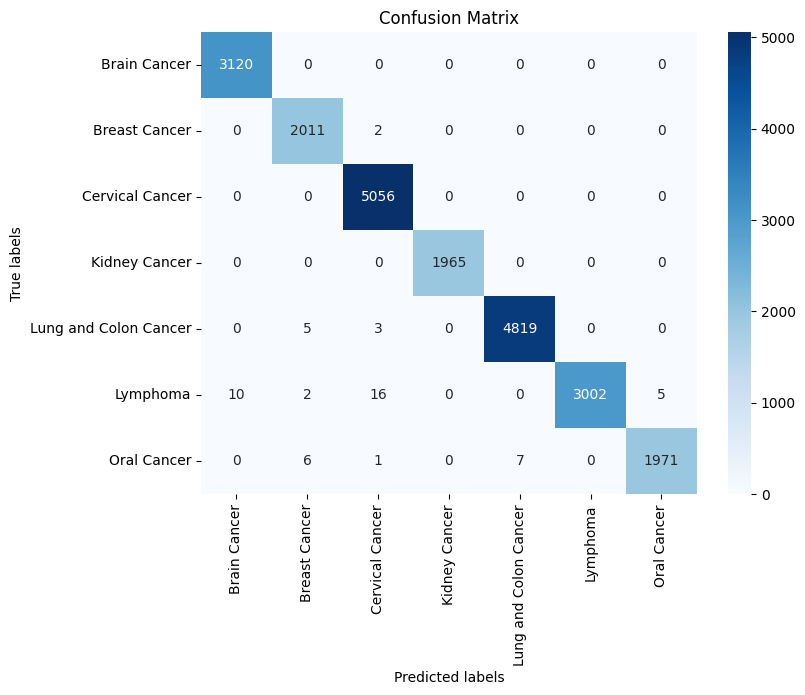


Model saved as organ_classifier_cnn.pth


In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Config
DATA_DIR = 'actual_data'    # <-- new dataset
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")

# Define transforms
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

# Load dataset
dataset = datasets.ImageFolder(root=DATA_DIR, transform=transform)
class_names = dataset.classes
num_classes = len(class_names)

print(f"Found classes: {class_names}")
print(f"Number of classes: {num_classes}")

# Split into train & test (80/20)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_ds, test_ds = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

# Define custom CNN
class CancerCNN(nn.Module):
    def __init__(self, num_classes):
        super(CancerCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128*16*16, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Initialize model, loss, optimizer
model = CancerCNN(num_classes=num_classes).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training loop
print("Starting training...")
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {epoch_loss:.4f}")

print("Training complete.\n")

# Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Classification report & confusion matrix
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Save model
torch.save(model.state_dict(), "organ_classifier_cnn.pth")
print("\nModel saved as organ_classifier_cnn.pth")


In [6]:
from PIL import Image

# Path to unseen image
IMAGE_PATH = 'normal.jpg'  # <-- change to your test image path

# Load and preprocess
image = Image.open(IMAGE_PATH).convert('RGB')
input_tensor = transform(image).unsqueeze(0).to(DEVICE)  # shape: (1, 3, 128, 128)

# Load model from saved file (if model already in memory, you can skip re-loading)
model = CancerCNN(num_classes=num_classes).to(DEVICE)
model.load_state_dict(torch.load("organ_classifier_cnn.pth", map_location=DEVICE))
model.eval()

# Predict
with torch.no_grad():
    outputs = model(input_tensor)
    _, predicted = torch.max(outputs, 1)
    predicted_class = class_names[predicted.item()]

print(f"✅ Predicted organ cancer type: {predicted_class}")


✅ Predicted organ cancer type: Kidney Cancer


C:\Users\srini\AppData\Local\Temp\ipykernel_18740\3233850596.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("organ_classifier_cnn.pth"